[INFO] Loading training data...


100%|██████████| 5000/5000 [08:23<00:00,  9.93it/s]


[INFO] Training SVM (RBF kernel)...

✅ Validation Accuracy: 0.7750
📉 Log Loss: 0.4955

📄 Classification Report:
               precision    recall  f1-score   support

         Cat       0.77      0.78      0.78       500
         Dog       0.78      0.77      0.77       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.77      1000
weighted avg       0.78      0.78      0.77      1000



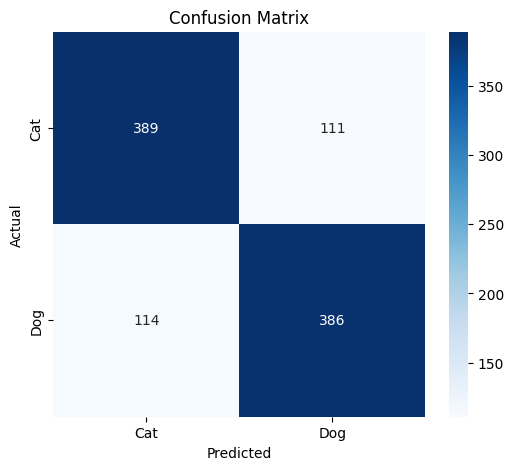

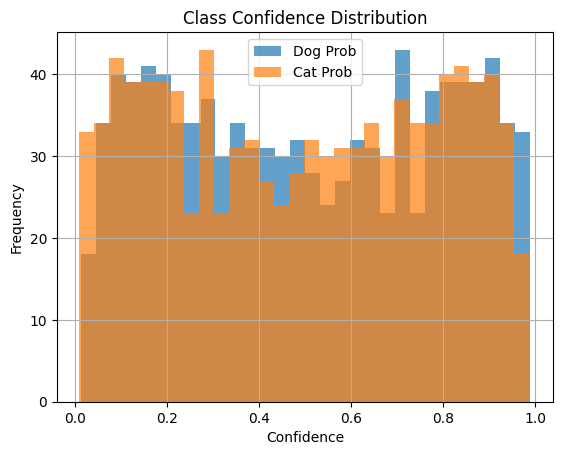


🖼️ Random Predictions with Confidence:


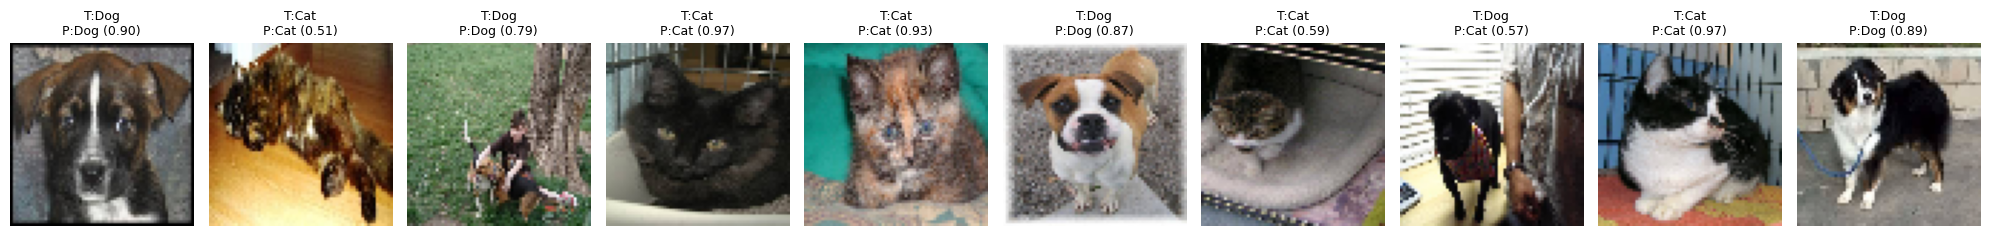

[INFO] Predicting on test1 folder...


100%|██████████| 12500/12500 [21:17<00:00,  9.78it/s]


✅ submission.csv saved!

🔍 Predicting a random image from validation set:


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


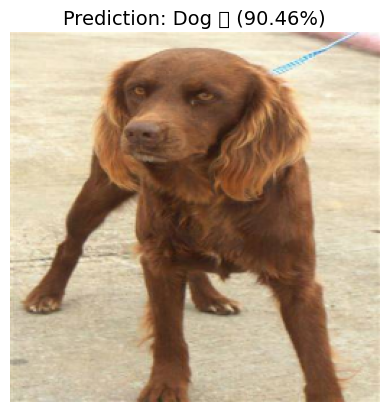


📂 File: dog.11838.jpg
✅ Predicted: Dog 🐶 with confidence 90.46%


In [11]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import seaborn as sns
import random

# 📁 Paths
train_dir = "/kaggle/input/dogs-vs-cats/dogs-vs-cats/train"
test_dir = "/kaggle/input/dogs-vs-cats/dogs-vs-cats/test1"
img_size = (128, 128)
limit = 5000  # use more if faster runtime

# 🔧 Feature Extractor
def extract_hog_color(img):
    img = cv2.resize(img, img_size)
    channels = cv2.split(img)
    features = []
    for ch in channels:
        feat, _ = hog(ch, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, channel_axis=None)
        features.extend(feat)
    return np.array(features)

# 🔄 Load Dataset
hog_features, labels, filenames = [], [], []
files = os.listdir(train_dir)[:limit]

print("[INFO] Loading training data...")
for fname in tqdm(files):
    path = os.path.join(train_dir, fname)
    label = 1 if "dog" in fname else 0
    img = cv2.imread(path)
    feat = extract_hog_color(img)
    hog_features.append(feat)
    labels.append(label)
    filenames.append(fname)

X = np.array(hog_features)
y = np.array(labels)

# 🔀 Train/Validation Split
X_train, X_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
    X, y, filenames, test_size=0.2, stratify=y, random_state=42
)

# 🧠 Train SVM
print("[INFO] Training SVM (RBF kernel)...")
svm = SVC(kernel="rbf", probability=True)
svm.fit(X_train, y_train)

# 📊 Validation Evaluation
y_pred = svm.predict(X_val)
y_prob = svm.predict_proba(X_val)

acc = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_prob)
print(f"\n✅ Validation Accuracy: {acc:.4f}")
print(f"📉 Log Loss: {loss:.4f}")
print("\n📄 Classification Report:\n", classification_report(y_val, y_pred, target_names=["Cat", "Dog"]))

# 📉 Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 📈 Confidence Histogram
plt.hist(y_prob[:, 1], bins=30, alpha=0.7, label='Dog Prob')
plt.hist(y_prob[:, 0], bins=30, alpha=0.7, label='Cat Prob')
plt.title("Class Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# 🖼️ Show Random Predictions with Confidence
def show_predictions(count=10):
    idxs = random.sample(range(len(y_val)), count)
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(idxs):
        true = 'Dog' if y_val[idx] else 'Cat'
        pred = 'Dog' if y_pred[idx] else 'Cat'
        prob = y_prob[idx][y_pred[idx]]
        fname = filenames_val[idx]
        img = cv2.imread(os.path.join(train_dir, fname))
        img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (64, 64))
        plt.subplot(1, count, i+1)
        plt.imshow(img)
        plt.title(f"T:{true}\nP:{pred} ({prob:.2f})", fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n🖼️ Random Predictions with Confidence:")
show_predictions(10)

# 📤 Predict on Test Data for Kaggle submission
print("[INFO] Predicting on test1 folder...")
test_files = os.listdir(test_dir)
test_feats, test_ids = [], []

for fname in tqdm(test_files):
    img_path = os.path.join(test_dir, fname)
    img = cv2.imread(img_path)
    feat = extract_hog_color(img)
    test_feats.append(feat)
    test_ids.append(int(fname.split('.')[0]))

X_test = np.array(test_feats)
y_test_prob = svm.predict_proba(X_test)[:, 1]  # Probability of 'dog'

submission = pd.DataFrame({
    "id": test_ids,
    "label": y_test_prob
}).sort_values("id")

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")

# 🔍 Custom Prediction from Validation Set
def predict_custom_val(index=None):
    if index is None:
        index = random.choice(range(len(X_val)))
    img_path = os.path.join(train_dir, filenames_val[index])
    img = cv2.imread(img_path)
    feat = extract_hog_color(img).reshape(1, -1)
    prob = svm.predict_proba(feat)[0]
    pred = 'Dog 🐶' if prob[1] > 0.5 else 'Cat 🐱'
    conf = prob[1] if prob[1] > 0.5 else 1 - prob[1]
    img_disp = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (256, 256))

    plt.imshow(img_disp)
    plt.title(f"Prediction: {pred} ({conf*100:.2f}%)", fontsize=14)
    plt.axis('off')
    plt.show()

    print(f"\n📂 File: {filenames_val[index]}")
    print(f"✅ Predicted: {pred} with confidence {conf*100:.2f}%")

print("\n🔍 Predicting a random image from validation set:")
predict_custom_val()


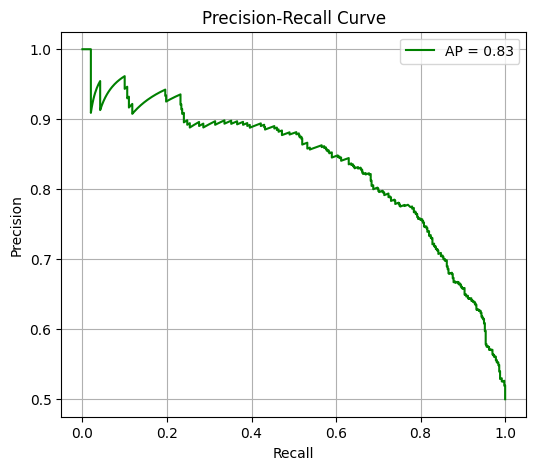

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_val, y_prob[:, 1])
ap_score = average_precision_score(y_val, y_prob[:, 1])

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


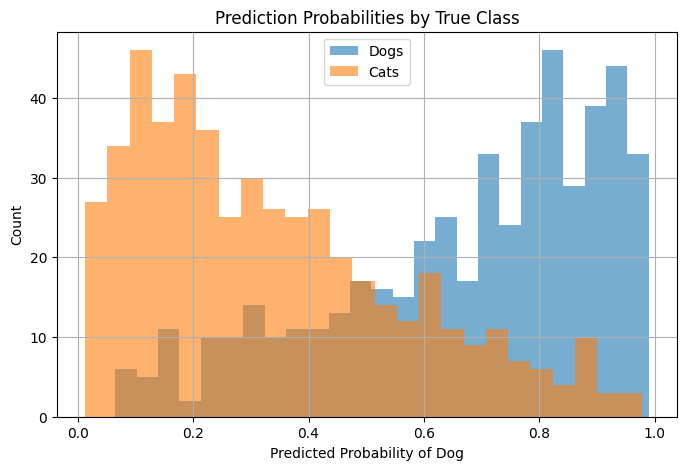

In [13]:
plt.figure(figsize=(8, 5))
dog_probs = y_prob[y_val == 1][:, 1]
cat_probs = y_prob[y_val == 0][:, 1]

plt.hist(dog_probs, bins=25, alpha=0.6, label="Dogs")
plt.hist(cat_probs, bins=25, alpha=0.6, label="Cats")
plt.title("Prediction Probabilities by True Class")
plt.xlabel("Predicted Probability of Dog")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


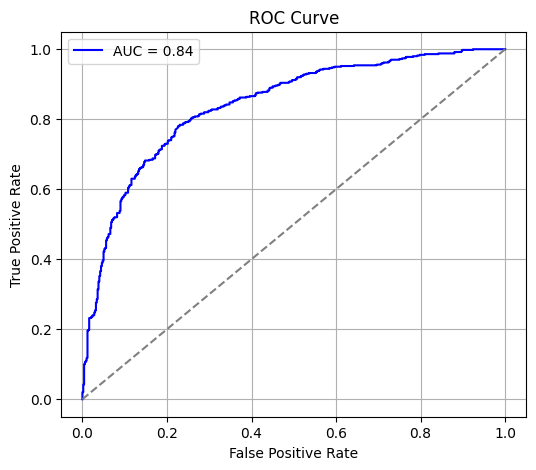

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_val, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


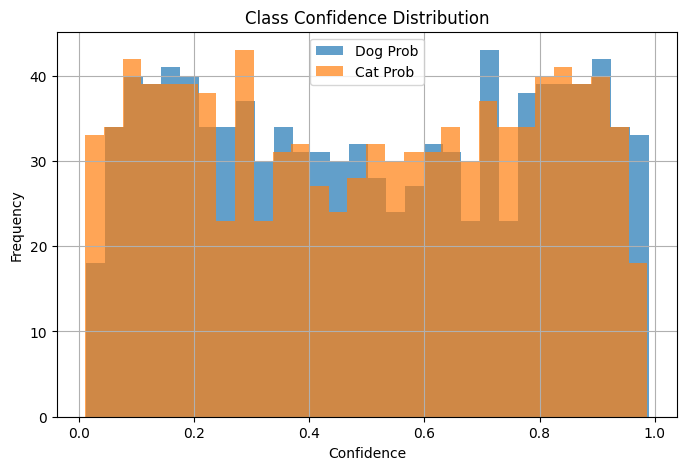

In [16]:
plt.figure(figsize=(8, 5))
plt.hist(y_prob[:, 1], bins=30, alpha=0.7, label='Dog Prob')
plt.hist(y_prob[:, 0], bins=30, alpha=0.7, label='Cat Prob')
plt.title("Class Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


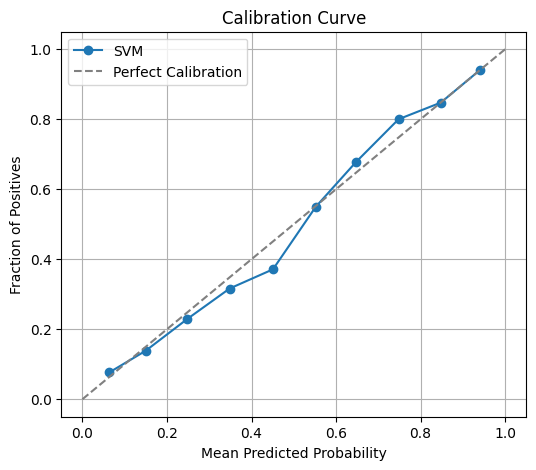

In [19]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val, y_prob[:, 1], n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label='SVM')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.title("Calibration Curve")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.show()


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

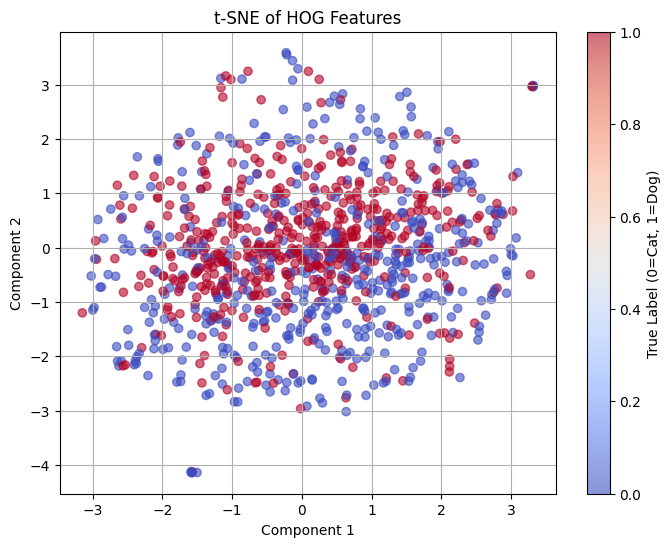

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_val)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_val, cmap='coolwarm', alpha=0.6)
plt.title("t-SNE of HOG Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label='True Label (0=Cat, 1=Dog)')
plt.grid(True)
plt.show()


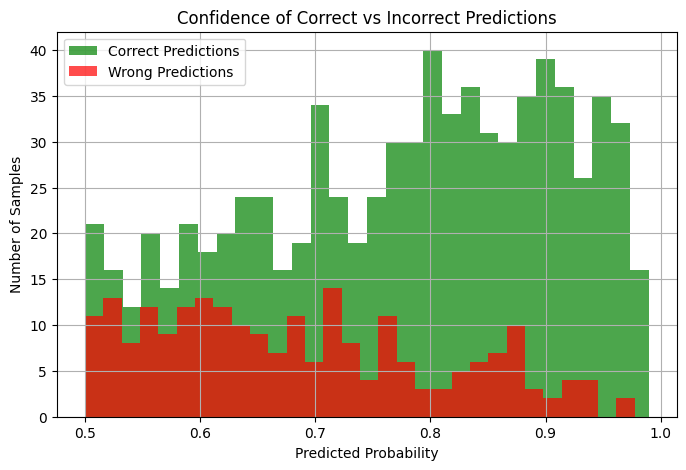

In [22]:
correct_idx = np.where(y_pred == y_val)[0]
wrong_idx = np.where(y_pred != y_val)[0]

correct_probs = [y_prob[i][y_pred[i]] for i in correct_idx]
wrong_probs = [y_prob[i][y_pred[i]] for i in wrong_idx]

plt.figure(figsize=(8, 5))
plt.hist(correct_probs, bins=30, alpha=0.7, label="Correct Predictions", color='green')
plt.hist(wrong_probs, bins=30, alpha=0.7, label="Wrong Predictions", color='red')
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Samples")
plt.title("Confidence of Correct vs Incorrect Predictions")
plt.legend()
plt.grid(True)
plt.show()


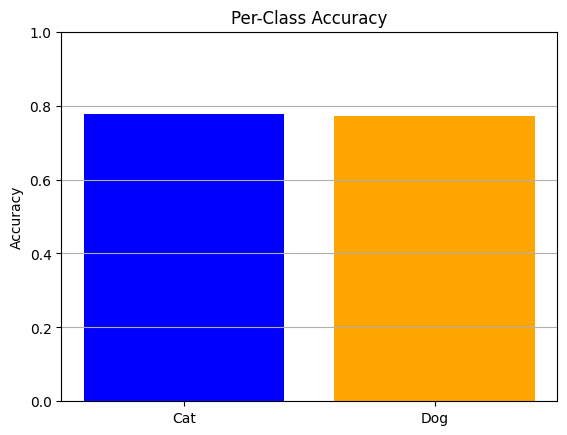

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.bar(['Cat', 'Dog'], class_accuracy, color=['blue', 'orange'])
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()


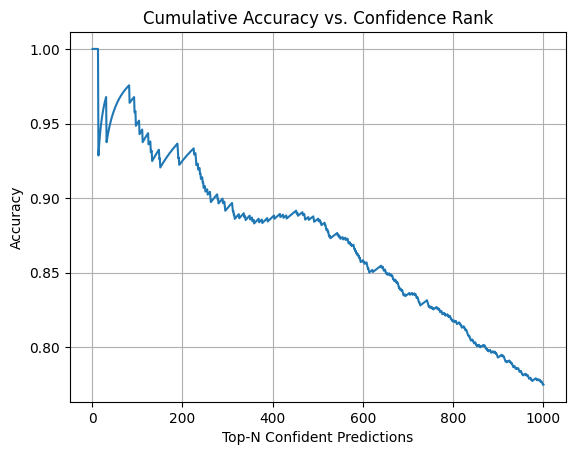

In [24]:
confidences = np.max(y_prob, axis=1)
sorted_indices = np.argsort(-confidences)
accuracies = []

correct = 0
for i, idx in enumerate(sorted_indices):
    if y_val[idx] == y_pred[idx]:
        correct += 1
    accuracies.append(correct / (i + 1))

plt.plot(range(1, len(accuracies)+1), accuracies)
plt.title("Cumulative Accuracy vs. Confidence Rank")
plt.xlabel("Top-N Confident Predictions")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


[INFO] Fitting t-SNE using SVM predicted labels...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

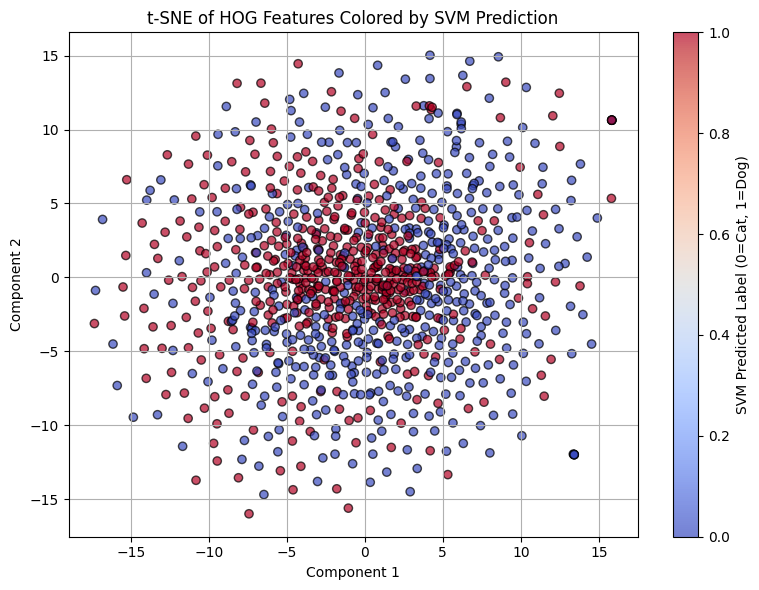

In [26]:
# Must run before anything else
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 🔁 Use predicted labels instead of true labels
# y_pred should be your predicted class labels from the SVM
# X_val = HOG features used for validation

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500, init='pca', learning_rate='auto')

print("[INFO] Fitting t-SNE using SVM predicted labels...")
X_2d = tsne.fit_transform(X_val)

# Plot with predicted labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=y_pred,  # <- predicted labels
    cmap='coolwarm', alpha=0.7, edgecolor='k'
)

plt.title("t-SNE of HOG Features Colored by SVM Prediction")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label='SVM Predicted Label (0=Cat, 1=Dog)')
plt.grid(True)
plt.tight_layout()
plt.show()


2025-07-11 13:14:20.431197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752239660.629800      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752239660.685307      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


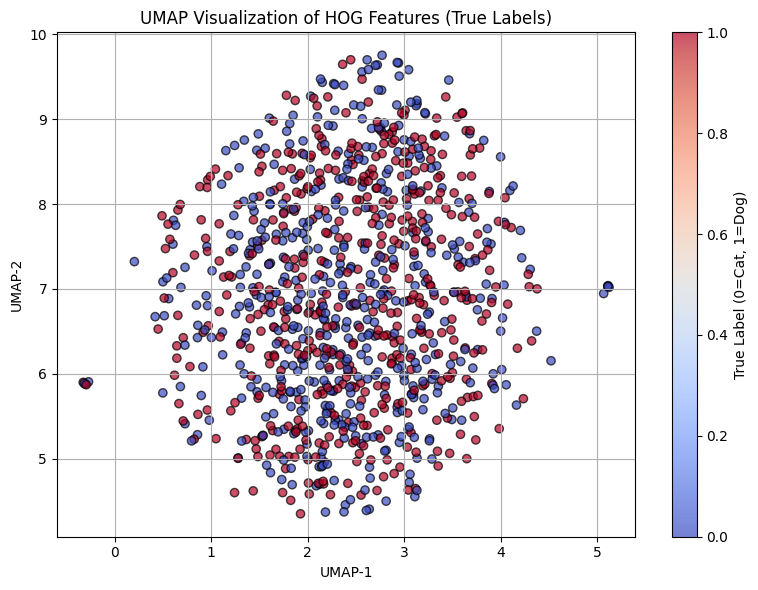

In [27]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Fit UMAP on HOG features
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_val)

# Plot using true labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=y_val, cmap='coolwarm', alpha=0.7, edgecolor='k'
)

plt.title("UMAP Visualization of HOG Features (True Labels)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label='True Label (0=Cat, 1=Dog)')
plt.grid(True)
plt.tight_layout()
plt.show()
